In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# %cd /content/drive/My\ Drive/CS231N/project/Confounder-Aware-CNN-Visualization-master
%cd /Users/elissali/Documents/GitHub/cs231n-adni/new_code

/Users/elissali/Documents/GitHub/cs231n-adni/new_code


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy.stats as st
import itertools
import statsmodels.api as sm
import torch

import sys
import argparse
import os
import glob 

# visualize saliency
import matplotlib
import matplotlib.pyplot as plt

import data, model, interpretation, utils, vis_utils

(251, 64, 64, 64, 1) (251,)
torch.Size([32, 1])


# Gather data
We need a set of images, their corresponding labels, and the corresponding ages of the patient for each image. We use our unaugmented test set for this analysis.

[moved to data.py] Here's the code to isolate the ages of our test set.

Manually verify that above ages correspond to the test data properly. Below, we use each test data's filename in place of the actual image. We can see that the first 3 test data belong to patient 002_S_0816, and the next few belong to patient 002_S_0938. Correspondingly, the ages are 70.8 and 82.2, which is correct, according to the spreadsheet.

In [5]:
# We only get the ages for the first 251 examples from the test set (the real examples)
# so we also need to truncate the test data and test labels.
def get_dummy_test_data_unaugmented():
    # Load the data
    file_idx = np.genfromtxt('./subjects_idx.txt', dtype='str') 
    fold_idx = np.loadtxt('fold.txt')                   # to keep same-patient images together
    label = np.loadtxt('dx.txt')
    np.random.seed(seed=0)

    subject_num = file_idx.shape[0]
    print("data.py line 13: ", subject_num)

    data = []
    for img_idx in file_idx:
        data.append(img_idx)
    print(data)
    print(len(data))

    print("data.py: line 39: finished loading stuff")

    # partition entire dataset into train, val, test
    # fold_idx goes from (0,4); separating these arbitrarily based on fold_idx
    test_idx = (fold_idx == 4)
    print(test_idx)

    test_data = []
    test_label = []
    for i in range(len(data)):
      if test_idx[i]:
        test_data.append(data[i])
        test_label.append(label[i])
    
    print(len(test_data), len(test_label))
    return test_data, test_label

test_data, test_labels = get_dummy_test_data_unaugmented()
print(test_data)
print(test_labels)


data.py line 13:  1334
['002_S_0295-2006-04-18_08_20_30.0.nii.gz', '002_S_0295-2006-11-02_08_16_44.0.nii.gz', '002_S_0295-2007-05-25_07_12_36.0.nii.gz', '002_S_0295-2008-07-23_14_51_41.0.nii.gz', '002_S_0295-2009-05-22_07_00_57.0.nii.gz', '002_S_0295-2009-05-22_07_09_05.0.nii.gz', '002_S_0295-2010-05-13_06_37_21.0.nii.gz', '002_S_0413-2006-05-02_12_31_52.0.nii.gz', '002_S_0413-2006-11-15_09_30_01.0.nii.gz', '002_S_0413-2007-06-01_07_04_09.0.nii.gz', '002_S_0413-2008-07-31_14_39_56.0.nii.gz', '002_S_0413-2009-05-04_14_34_42.0.nii.gz', '002_S_0413-2010-05-06_12_37_46.0.nii.gz', '002_S_0559-2006-05-23_15_31_00.0.nii.gz', '002_S_0559-2007-07-13_07_05_10.0.nii.gz', '002_S_0559-2008-08-15_18_09_30.0.nii.gz', '002_S_0559-2009-06-30_17_19_02.0.nii.gz', '002_S_0619-2006-06-01_20_04_45.0.nii.gz', '002_S_0619-2007-06-22_07_06_17.0.nii.gz', '002_S_0685-2006-07-06_10_36_49.0.nii.gz', '002_S_0685-2007-01-22_15_10_49.0.nii.gz', '002_S_0685-2007-08-02_14_17_55.0.nii.gz', '002_S_0685-2008-08-22_10_05_4

In [6]:
test_data = torch.Tensor(np.load("test_data.npy"))
test_labels = torch.Tensor(np.load("test_label.npy"))

test_data = np.reshape(test_data, (251, 1, 64, 64, 64))
print(test_data.shape)

torch.Size([251, 64, 64, 64, 1])


Next, we need to get the pretrained model and run the test data through its feature extractor.

# Univariate Testing for Confounding Effects
After the feature extractor, we end up with (4, 4, 4) images and 16 filters. 

We apply a dense layer to flatten this, to end up with 4 * 4 * 4 * 16=1024 dense features for each image.

Now we perform a GLM analysis for each of the 1024 dense features $$y = c+\alpha*mf + \beta * cf$$

We claim that $y$ is confounded if $p$-value for $\beta$ is significant ($p<0.05$). 

In [9]:
cf = nb_get_ages() # (n_samples,) -> ages

cannot convert 
cannot convert 
cannot convert 
cannot convert 
number of examples:  1334
number of unmatched examples: 0
[70.8 70.8 70.8 82.2 82.2 82.2 82.2 88.6 88.6 88.6 88.6 84.9 70.7 70.7
 70.7 70.7 70.7 70.7 70.7 71.5 71.5 71.5 71.5 74.4 74.4 74.4 74.  74.
 74.5 74.5 74.5 74.5 73.4 64.9 64.9 64.9 64.9 76.6 76.6 76.6 75.8 75.8
 75.8 75.8 75.3 74.9 74.9 74.9 74.9 74.9 83.  83.  83.  83.  80.2 81.3
 81.3 81.3 81.3 81.3 86.3 78.5 78.5 78.5 74.5 74.5 74.5 74.5 72.2 72.2
 70.1 70.1 70.1 70.1 70.1 70.1 70.1 77.  77.  77.  77.  70.6 70.6 70.6
 70.6 70.6 70.6 77.2 77.2 77.2 75.3 75.3 75.3 75.3 70.5 70.5 70.5 70.5
 70.5 71.1 71.1 71.1 87.6 87.6 87.6 87.6 87.6 78.6 78.6 57.1 57.1 57.1
 57.1 78.3 78.3 78.3 78.3 78.3 77.6 77.6 78.3 78.3 78.3 78.3 78.3 62.
 62.  62.  62.  62.  77.1 77.1 77.1 76.9 76.9 76.9 77.3 77.3 71.4 71.4
 71.4 71.4 71.4 70.6 70.6 70.6 70.6 77.3 77.3 77.3 77.3 79.2 79.2 74.8
 74.8 77.4 62.  74.6 74.6 74.6 74.6 71.  78.  82.6 85.1 85.1 85.1 76.7
 76.7 76.7 77.3 77.3 77.3 77

In [11]:
mask = glm.perform_glm()

/Users/elissali/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


In [68]:
confounder_mod = model.Confounder3DCNN(mask=mask, in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                    conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [91]:
confounder_ex = interpretation.sensitivity_analysis(confounder_mod, test_data[220], cuda=False, verbose=True)

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
Image was classified as 1 with probability 0.9974684715270996
one hot output:  tensor([[[0.],
         [1.]]])


In [90]:
test_labels[220]

tensor(1.)

tensor(-1.1191) tensor(2.6709) 8.526513e-14 6.0795881614469955e-05


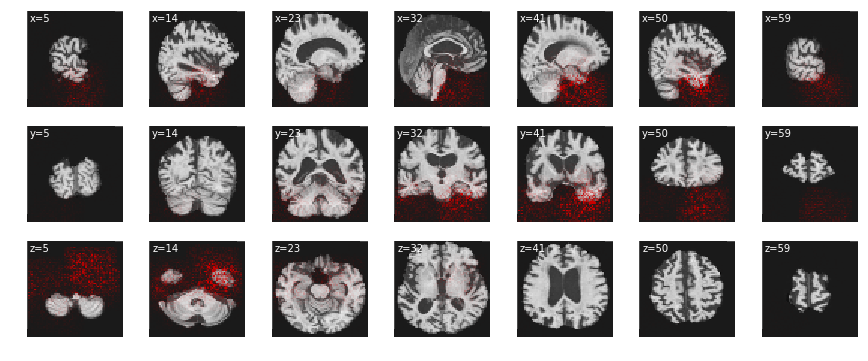

In [92]:
vis_utils.plot_slices(test_data[220][0], num_slices = 7, overlay=confounder_ex[0], 
                  overlay_vmax=np.percentile(confounder_ex, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [93]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                            conv_act='relu', fc_act='tanh').to(torch.device('cpu'))
net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])
net.eval()

regular_saliency = interpretation.sensitivity_analysis(net, test_data[220], cuda=False, verbose=True)

Image was classified as 1 with probability 0.9977214932441711
one hot output:  tensor([[[0.],
         [1.]]])


tensor(-1.1191) tensor(2.6709) 3.907985e-13 4.064317332086e-05


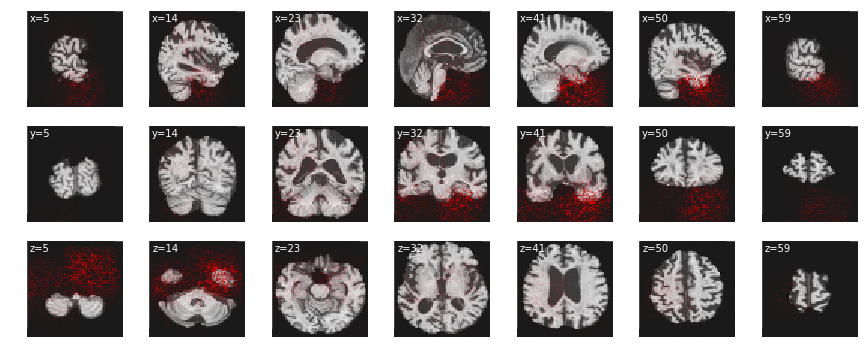

In [95]:
vis_utils.plot_slices(test_data[220][0], num_slices = 7, overlay=regular_saliency[0], 
                  overlay_vmax=np.percentile(regular_saliency, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

# Guided Backprop

In [96]:
confounder_backprop = interpretation.guided_backprop(confounder_mod, test_data[220], cuda=False, verbose=True)

Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
Image was classified as 1 with probability 0.9974684715270996
one hot output:  tensor([[[0.],
         [1.]]])
Removing 4 hook(s)


tensor(-1.1191) tensor(2.6709) 0.0 3.182026444847157e-05


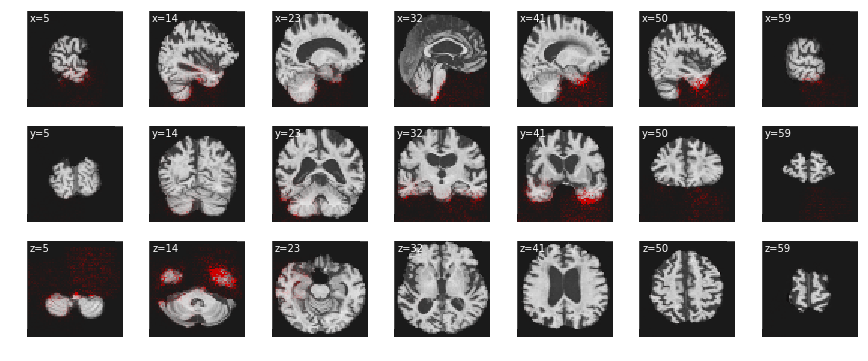

In [98]:
vis_utils.plot_slices(test_data[220][0], overlay=confounder_backprop[0], 
                  overlay_vmax=np.percentile(confounder_backprop, 99.9))

In [99]:
reg_backprop = interpretation.guided_backprop(net, test_data[220], cuda=False, verbose=True)

Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Image was classified as 1 with probability 0.9977214932441711
one hot output:  tensor([[[0.],
         [1.]]])
Removing 4 hook(s)


tensor(-1.1191) tensor(2.6709) 0.0 2.136792680357784e-05


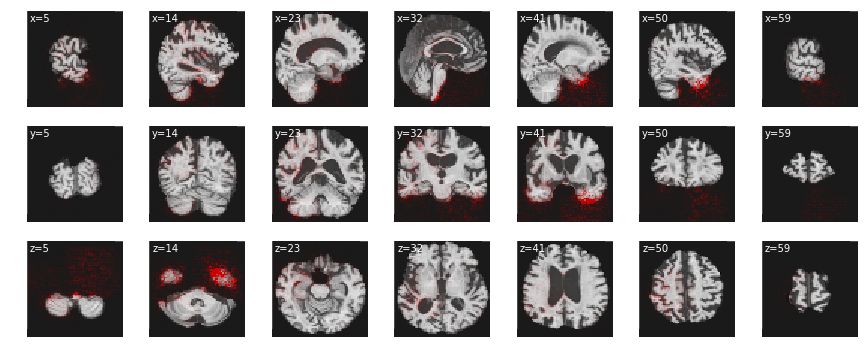

In [100]:
vis_utils.plot_slices(test_data[220][0], overlay=reg_backprop[0], 
                  overlay_vmax=np.percentile(reg_backprop, 99.9))

# Occlusion

In [101]:
confounder_occ = interpretation.occlusion(confounder_mod, test_data[220], size=10, stride=5, occlusion_value = 0, cuda=False, resize=True, verbose=True)

three_d:  True
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
Image was classified as 1 with probability 0.9974684715270996


tensor([[ 1.8385,  1.3779, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 2.0782,  1.3605, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 2.2238,  1.3532, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 2.2075,  1.1781, -0.3990,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.9903,  1.3100, -0.4098,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7898,  1.3075, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.5028,  1.0791, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 2.0493,  1.0522, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 2.1692,  1.2367, -0.3986,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 2.0064,  1.3228, -0.3763,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7812,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7658,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7535,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.6726,  1.3510, -0.3646,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[1.7434, 1.3510, 0.2572,  ..., 0.2755, 0.7905, 0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.0503,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.1228,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 2.1548,  1.3079, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0

tensor([[ 1.7434,  1.4432, -0.4138,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.5831,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3979,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.2651,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7481,  1.3510, -0.3939,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.4413,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.4211,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3777,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3768,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.9974,  1.4888, -0.3139,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7615,  1.3672, -0.3450,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.4543, -0.2986,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3290,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.1781,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.6072,  1.2104, -0.6988,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7531,  1.3029, -0.6093,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3678, -0.5393,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.6026,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.2636,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7266,  1.3510, -0.2729,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[1.7289, 1.3510, 0.0587,  ..., 0.2755, 0.7905, 0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3628,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3291,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.2875,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7219,  0.3175, -0.3253,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7297,  0.8552, -0.2688,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[1.5671, 0.6481, 0.0231,  ..., 0.2755, 0.7905, 0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[1.7643, 1.8457, 0.1015,  ..., 0.2755, 0.7905, 0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[1.7434, 1.4812, 0.6432,  ..., 0.2755, 0.7905, 0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0

tensor([[ 1.2820,  1.3668, -0.3312,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 0.8767,  1.4591, -0.5488,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[1.7124, 1.4711, 0.0532,  ..., 0.2755, 0.7905, 0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.9957,  1.4251, -0.6490,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7060,  1.2431, -0.6808,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.3906,  1.3478, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.3184,  1.5077, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.0010,  1.2994, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.5784,  1.1526, -0.3539,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.5318,  1.5195, -0.2319,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.6469,  1.3597, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.8861,  1.4058, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 0.1425,  1.5632, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[-0.1941,  1.6348, -0.3154,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[-0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 0.0738,  1.4577, -0.4564,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.00

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7444,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7497,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7301,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7402,  1.3510, -0.3824,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.4599,  1.3918, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.5267,  1.2646, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.4595,  1.3327, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.5160,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3683,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.6766,  1.3807, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.8618,  1.7914, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.6988,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.6988,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.4887,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7891,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7908,  1.2505, -0.1269,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7312,  1.3437, -0.1905,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3896, -0.3256,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.2412,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.4587,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.6183,  1.2315, -0.2418,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7415,  1.3299, -0.6988,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3512, -0.6988,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.6659,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.5796,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7549,  1.3510, -0.4065,  ...,  0.2873,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7447,  1.3510, -0.4061,  ...,  0.2894,  0.7905,  0.5512]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5512]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7435,  1.3510, -0.3850,  ...,  0.2835,  0.7905,  0.5528]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5528]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3748,  ...,  0.2774,  0.7905,  0.5536]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5536]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.4010,  ...,  0.2747,  0.7905,  0.5502]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2907,  0.7893,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7893, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2595,  0.7871,  0.5503]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7871, 0.5503]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2749,  0.7841,  0.5591]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7841, 0.5591]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2868,  0.8220,  0.5672]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8220, 0.5672]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2965,  0.8252,  0.5700]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7472,  1.3347, -0.3780,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7433,  1.3592, -0.3581,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7429,  1.3498, -0.3382,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3533, -0.3631,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3786,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7564,  1.3210, -0.3813,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7479,  1.3539, -0.3700,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7429,  1.3525, -0.3561,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3542, -0.3541,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3938,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7534,  1.3510, -0.3828,  ...,  0.2602,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7598,  1.3510, -0.3864,  ...,  0.2728,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7440,  1.3510, -0.3850,  ...,  0.2907,  0.7905,  0.5496]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5496]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7433,  1.3510, -0.3817,  ...,  0.2777,  0.7905,  0.5496]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5496]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3835,  ...,  0.2729,  0.7905,  0.5517]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2777,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2864,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3710,  0.7950,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7950, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3595,  0.7703,  0.5392]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7703, 0.5392]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2464,  0.7856,  0.5692]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2912,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2768,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3011,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3743,  0.8081,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8081, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3999,  0.8295,  0.5607]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2704,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2392,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2556,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3628,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7893,  0.6309]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7893, 0.6309]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2676,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2796,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3383,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2785,  0.7905,  0.5299]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5299]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5471]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5471]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5519]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5519]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2644,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3499,  0.9358,  0.7423]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.9358, 0.7423]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2714,  0.8835,  0.6921]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8835, 0.6921]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7656,  0.4012]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7656, 0.4012]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7404,  0.4763]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7404, 0.4763]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2733,  0.7051,  0.4474]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7051, 0.4474]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3270,  0.7553,  0.4557]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7553, 0.4557]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2654,  0.7598,  0.5766]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7598, 0.5766]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7308,  0.8485]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7308, 0.8485]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7514,  0.6699]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3720,  0.9410,  0.5474]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.9410, 0.5474]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.6107,  0.8630,  0.5512]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8630, 0.5512]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.5242,  0.8753,  0.5020]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8753, 0.5020]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3543,  0.8589,  0.6462]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8589, 0.6462]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2910,  0.7840,  0.4534]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2605,  1.1193,  0.5392]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 1.1193, 0.5392]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2458,  0.5902,  0.4454]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.5902, 0.4454]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3201,  0.6529,  0.3558]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.6529, 0.3558]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2368,  0.7887,  0.3393]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7887, 0.3393]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3004,  0.8560,  0.5499]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.1662,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2573,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3573,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3262,  0.7905,  0.5501]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5501]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3111,  0.7905,  0.5473]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2901,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3715,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3579,  0.8357,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8357, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3386,  0.7640,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7640, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.3157,  0.7998,  0.5530]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2767,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2823,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2722,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7836,  0.4433]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7836, 0.4433]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7850,  0.5342]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7850, 0.5342]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2875,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2399,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.9748, 0.5292]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.8297,  0.6580]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8297, 0.6580]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.8013,  0.6387]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8013, 0.6387]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2859,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor(

tensor(-1.1191) tensor(2.6709) 0.0 0.008957624435424805


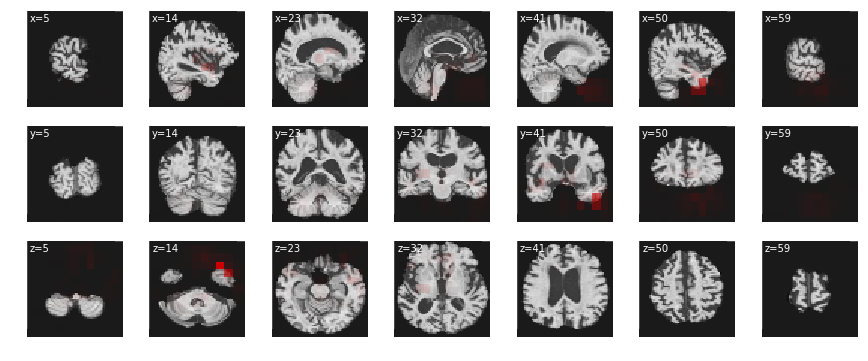

In [102]:
vis_utils.plot_slices(test_data[220][0], overlay=confounder_occ, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

# Brain Area Occ

In [104]:
from tqdm import tqdm_notebook

In [106]:
brain_map = vis_utils.load_nifti('aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    area_mask = vis_utils.resize_image(area_mask, test_data[0][0].shape, interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

def get_relevance_per_area(relevance_map, normalize=True):
    relevances = np.zeros(len(area_masks))
    print(relevances.shape)
    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)
    if normalize:
        relevances /= relevances.sum()  # make all areas sum to 1

    # Merge left and right areas.
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    return sorted(zip(merged_area_names, merged_relevances), key=lambda x: x[1], reverse=True)

In [107]:
confounder_bm = interpretation.area_occlusion(confounder_mod, test_data[220], area_masks, cuda=False, verbose=True)

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
Image was classified as 1 with probability 0.9974684715270996
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])


tensor([[ 1.7434,  1.3510, -0.5102,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.4683,  0.7876,  0.5641]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7876, 0.5641]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2355,  0.8942,  0.6385]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.8942, 0.6385]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7046,  1.3510, -0.3916,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2539,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2933,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7741,  1.2496, -0.3661,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7421,  1.3510, -0.4226,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2888,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7415,  1.3510, -0.4568,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2754,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7476,  1.3365, -0.1348,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.000

tensor([[ 1.7855,  1.3436, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
tensor([[ 1.7449,  1.3507, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])



tensor(-1.1191) tensor(2.6709) 0.0 0.0023072362


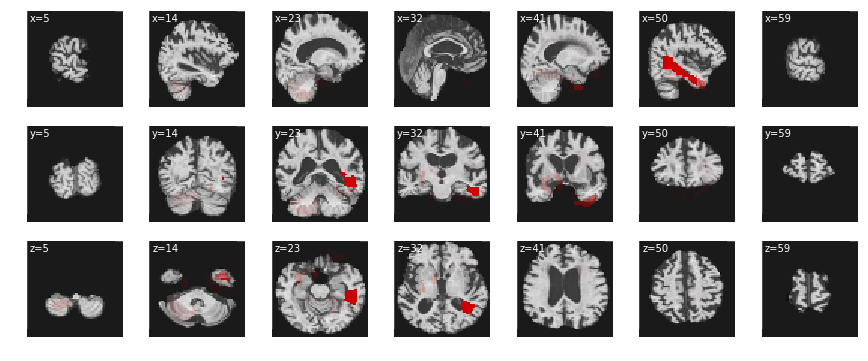

In [108]:
vis_utils.plot_slices(test_data[220][0], overlay=confounder_bm, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)

In [109]:
reg_bm = interpretation.area_occlusion(net, test_data[220], area_masks, cuda=False, verbose=True)

Image was classified as 1 with probability 0.9977214932441711
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])


tensor(-1.1191) tensor(2.6709) 0.0 0.0011768341


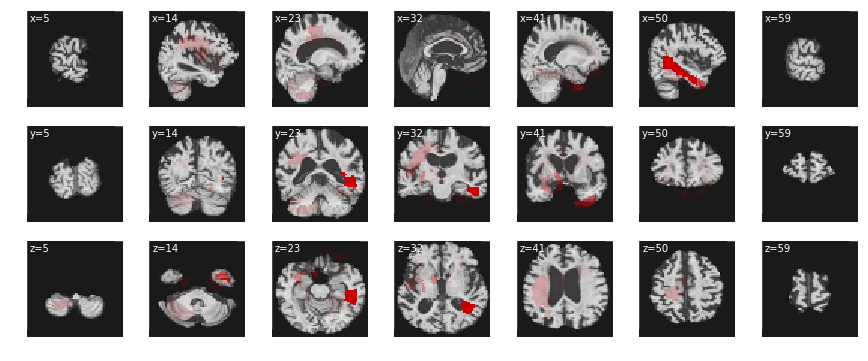

In [110]:
vis_utils.plot_slices(test_data[220][0], overlay=reg_bm, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)